# VUV

## Processing

In [1]:
import os 
import sys 

# path to python main folder in this project
libraries = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) 
sys.path.append(libraries) 

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import uproot

from ETL import ETL_Techniques 
from decompose import calibration
from time import time

PATH = os.path.abspath(os.path.join(os.getcwd(), (os.pardir+'/')*3)) # main path
print(PATH)

ROOT = os.path.join(PATH, "data/sample_particles_v2/")
print(ROOT)

################################################################################
# electron signals
################################################################################
# electron signals
DATA = os.path.join(PATH, 'data_preproc/')

e_signals = pd.read_csv(os.path.join(DATA, 'LightSignal_decomp_e_VUV.csv'), 
                        sep=',', index_col=0)

t = pd.read_csv(os.path.join(DATA, 'LightSignal_t.csv'), sep=';', index_col=0, 
                header=None)

t = np.array(t.iloc[0]).reshape(-1)

################################################################################
# General variables
################################################################################
# branches in the trees
branches_to_activate = ["stepX", "dE", "PDGcode", "eventID", "E", 
                        "energydepX", 'energydep']

# PMTs ids
PMTs = np.loadtxt(os.path.join(PATH, "data/PMT_IDs.txt"))
IdPMTs_L = [int(i) for i in PMTs if (i%2 == 0)] # even PMT IDs, left (X<0)
IdPMTs_R = [int(i) for i in PMTs if (i%2 != 0)] # odd PMT IDs, right (X>0)

# time of the ideal signal
t_path = os.path.join(PATH, 'data_preproc/LightSignal_t.csv')

t = pd.read_csv(t_path, sep=';', header=None) # t[0] is nonsense, remove it
t.set_index(0, inplace=True) # remove first time

t = np.array(t).reshape(-1).astype(np.int32)
t = t-5 # move to the edges of the bins to integrate

################################################################################
# MAIN LOOP
################################################################################
skip = os.path.join(ROOT, ".DS_Store/")

idx, energydepX, dE = [], [], []
m0 = time()

etl = ETL_Techniques(IdPMTs_L, IdPMTs_R)

ntree = 0
for folder in os.listdir(ROOT): 
    rel_PATH = os.path.join(ROOT, folder)
    rel_PATH += "/"
    
    if (rel_PATH == skip): continue # skip .DS_Store/ mac directory
    
    for f in os.listdir(rel_PATH):
        file = os.path.join(rel_PATH, f) # root file
        mi = time()
        
        # open trees file:
        with uproot.open(file) as rootfile: 
            
            tree = rootfile["opanatree/OpAnaTree"]
            branches = tree.arrays(branches_to_activate, library="np") 
            
            for entry in range(len(branches["eventID"])): # entries loop

                # in the decay of the muon, there are more particles apart of 
                # the Michel electron, dismiss the rest
                
                # dE_e, _, _, energydepX_e = etl.getElectron2EnergiesX0AndEnergydepx(
                #                                         branches["stepX"][entry], 
                #                                         branches["PDGcode"][entry],
                #                                         branches["dE"][entry],
                #                                         branches["E"][entry], 
                #                                         branches["energydepX"][entry]
                #                                         )
                
                dE_e, _ = etl.getElectronEnergyAndX0(branches["stepX"][entry],
                                                     branches["PDGcode"][entry],
                                                     branches["dE"][entry])
                
                energydep_e, energydepX_e = etl.getEnergyDepAndX(branches["PDGcode"][entry],
                                                                 branches["energydep"][entry],
                                                                 branches["energydepX"][entry],)
                
                idx.append(str(ntree)+'_'+str(entry+1))
                dE.append(dE_e) # MeV
                
                if len(energydepX_e)>0: 
                    # energydepX.append(np.abs(np.mean(energydepX_e)))
                    weighted_mean = np.abs(np.average(energydepX_e, 
                                                      weights=energydep_e))
                    energydepX.append(weighted_mean)
                else: 
                    energydepX.append(0)
                
            
        # finish of file
        print(f'Time spent with tree {ntree}: {time()-mi} (s).')
        # print(np.shape(list_dE), np.shape(list_integrate))
        ntree+=1
        
print(f'Total time processing data: {(time()-m0)/60}(min).')

dE=pd.Series(dE, index=idx)
energydepX=pd.Series(energydepX, index=idx)

dE = np.array(dE.loc[e_signals.index]).reshape(-1)
energydepX = np.array(energydepX.loc[e_signals.index]).reshape(-1)

integral_signal = []
for i in range(energydepX.shape[0]):
    integral_signal.append(np.trapz(e_signals.iloc[i,:], t))

integral_signal = np.array(integral_signal).reshape(-1)

/Users/javigamero/MyMac/DS_Master/TFM
/Users/javigamero/MyMac/DS_Master/TFM/data/sample_particles_v2/
Time spent with tree 0: 0.07879400253295898 (s).
Time spent with tree 1: 0.08152484893798828 (s).
Time spent with tree 2: 0.08185601234436035 (s).
Time spent with tree 3: 0.07510685920715332 (s).
Time spent with tree 4: 0.07933592796325684 (s).
Time spent with tree 5: 0.0806269645690918 (s).
Time spent with tree 6: 0.07955813407897949 (s).
Time spent with tree 7: 0.0729207992553711 (s).
Time spent with tree 8: 0.07739901542663574 (s).
Time spent with tree 9: 0.07428908348083496 (s).
Time spent with tree 10: 0.07582211494445801 (s).
Time spent with tree 11: 0.08105683326721191 (s).
Time spent with tree 12: 0.13188815116882324 (s).
Time spent with tree 13: 0.07738089561462402 (s).
Time spent with tree 14: 0.07958817481994629 (s).
Time spent with tree 15: 0.07520294189453125 (s).
Time spent with tree 16: 0.07888269424438477 (s).
Time spent with tree 17: 0.07867622375488281 (s).
Time spent

## 2D-Plot

[20, 11]


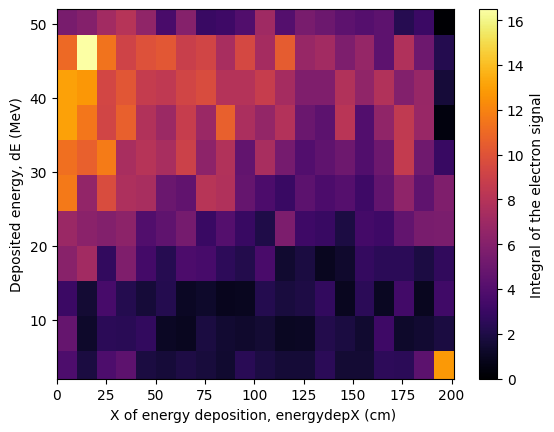

In [2]:
f = np.where((integral_signal<20000) & (dE>1) & (dE<56))

x = np.array(energydepX)[f]
y = np.array(dE)[f]
z = np.array(integral_signal)[f]
z_normalized = (z - min(z)) / (max(z) - min(z))

colormap = plt.get_cmap('inferno')

bins = [20, 11] # bins --> (width 10cm in dEX, X) and (width = 5MeV in dE, Y)
print(bins)
plt.hist2d(x, y, weights=z_normalized, bins=bins, cmap=colormap)
cbar = plt.colorbar()
cbar.set_label('Integral of the electron signal') 

plt.ylim(2,52)
plt.xlabel('X of energy deposition, energydepX (cm) ')
plt.ylabel('Deposited energy, dE (MeV)')
plt.show()

# VIS

## Processing

In [3]:
import os 
import sys 

# path to python main folder in this project
libraries = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) 
sys.path.append(libraries) 

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import uproot

from ETL import ETL_Techniques 
from decompose import calibration
from time import time

PATH = os.path.abspath(os.path.join(os.getcwd(), (os.pardir+'/')*3)) # main path
print(PATH)

ROOT = os.path.join(PATH, "data/sample_particles_v2/")
print(ROOT)

################################################################################
# electron signals
################################################################################
# electron signals
DATA = os.path.join(PATH, 'data_preproc/')

e_signals = pd.read_csv(os.path.join(DATA, 'LightSignal_decomp_e_VIS.csv'), 
                        sep=',', index_col=0)

t = pd.read_csv(os.path.join(DATA, 'LightSignal_t.csv'), sep=';', index_col=0, 
                header=None)

t = np.array(t.iloc[0]).reshape(-1)

################################################################################
# General variables
################################################################################
# branches in the trees
branches_to_activate = ["stepX", "dE", "PDGcode", "eventID", "E", 
                        "energydepX", 'energydep']

# PMTs ids
PMTs = np.loadtxt(os.path.join(PATH, "data/PMT_IDs.txt"))
IdPMTs_L = [int(i) for i in PMTs if (i%2 == 0)] # even PMT IDs, left (X<0)
IdPMTs_R = [int(i) for i in PMTs if (i%2 != 0)] # odd PMT IDs, right (X>0)

# time of the ideal signal
t_path = os.path.join(PATH, 'data_preproc/LightSignal_t.csv')

t = pd.read_csv(t_path, sep=';', header=None) # t[0] is nonsense, remove it
t.set_index(0, inplace=True) # remove first time

t = np.array(t).reshape(-1).astype(np.int32)
t = t-5 # move to the edges of the bins to integrate

################################################################################
# MAIN LOOP
################################################################################
skip = os.path.join(ROOT, ".DS_Store/")

idx, energydepX, dE = [], [], []
m0 = time()

etl = ETL_Techniques(IdPMTs_L, IdPMTs_R)

ntree = 0
for folder in os.listdir(ROOT): 
    rel_PATH = os.path.join(ROOT, folder)
    rel_PATH += "/"
    
    if (rel_PATH == skip): continue # skip .DS_Store/ mac directory
    
    for f in os.listdir(rel_PATH):
        file = os.path.join(rel_PATH, f) # root file
        mi = time()
        
        # open trees file:
        with uproot.open(file) as rootfile: 
            
            tree = rootfile["opanatree/OpAnaTree"]
            branches = tree.arrays(branches_to_activate, library="np") 
            
            for entry in range(len(branches["eventID"])): # entries loop

                # in the decay of the muon, there are more particles apart of 
                # the Michel electron, dismiss the rest
                
                # dE_e, _, _, energydepX_e = etl.getElectron2EnergiesX0AndEnergydepx(
                #                                         branches["stepX"][entry], 
                #                                         branches["PDGcode"][entry],
                #                                         branches["dE"][entry],
                #                                         branches["E"][entry], 
                #                                         branches["energydepX"][entry]
                #                                         )
                
                dE_e, _ = etl.getElectronEnergyAndX0(branches["stepX"][entry],
                                                     branches["PDGcode"][entry],
                                                     branches["dE"][entry])
                
                energydep_e, energydepX_e = etl.getEnergyDepAndX(branches["PDGcode"][entry],
                                                                 branches["energydep"][entry],
                                                                 branches["energydepX"][entry],)
                
                idx.append(str(ntree)+'_'+str(entry+1))
                dE.append(dE_e) # MeV
                
                if len(energydepX_e)>0: 
                    # energydepX.append(np.abs(np.mean(energydepX_e)))
                    weighted_mean = np.abs(np.average(energydepX_e, 
                                                      weights=energydep_e))
                    energydepX.append(weighted_mean)
                else: 
                    energydepX.append(0)
                
            
        # finish of file
        print(f'Time spent with tree {ntree}: {time()-mi} (s).')
        # print(np.shape(list_dE), np.shape(list_integrate))
        ntree+=1
        
print(f'Total time processing data: {(time()-m0)/60}(min).')

dE=pd.Series(dE, index=idx)
energydepX=pd.Series(energydepX, index=idx)

dE = np.array(dE.loc[e_signals.index]).reshape(-1)
energydepX = np.array(energydepX.loc[e_signals.index]).reshape(-1)

integral_signal = []
for i in range(energydepX.shape[0]):
    integral_signal.append(np.trapz(e_signals.iloc[i,:], t))

integral_signal = np.array(integral_signal).reshape(-1)

/Users/javigamero/MyMac/DS_Master/TFM
/Users/javigamero/MyMac/DS_Master/TFM/data/sample_particles_v2/
Time spent with tree 0: 0.07882499694824219 (s).
Time spent with tree 1: 0.0854482650756836 (s).
Time spent with tree 2: 0.09143400192260742 (s).
Time spent with tree 3: 0.08515620231628418 (s).
Time spent with tree 4: 0.07870292663574219 (s).
Time spent with tree 5: 0.13441109657287598 (s).
Time spent with tree 6: 0.08134913444519043 (s).
Time spent with tree 7: 0.0766139030456543 (s).
Time spent with tree 8: 0.08294010162353516 (s).
Time spent with tree 9: 0.08335375785827637 (s).
Time spent with tree 10: 0.07810306549072266 (s).
Time spent with tree 11: 0.08926010131835938 (s).
Time spent with tree 12: 0.0793001651763916 (s).
Time spent with tree 13: 0.07889914512634277 (s).
Time spent with tree 14: 0.08163189888000488 (s).
Time spent with tree 15: 0.07873392105102539 (s).
Time spent with tree 16: 0.08447003364562988 (s).
Time spent with tree 17: 0.14426803588867188 (s).
Time spent 

## 2D-Plot

[20, 11]


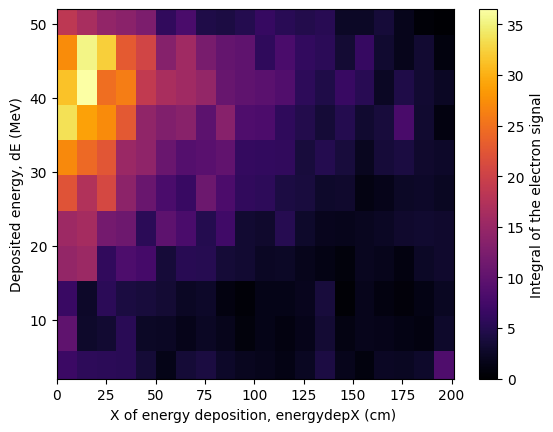

In [4]:
f = np.where((integral_signal<20000) & (dE>1) & (dE<56))

x = np.array(energydepX)[f]
y = np.array(dE)[f]
z = np.array(integral_signal)[f]
z_normalized = (z - min(z)) / (max(z) - min(z))

colormap = plt.get_cmap('inferno')

bins = [20, 11] # bins --> (width 10cm in dEX, X) and (width = 5MeV in dE, Y)
print(bins)
plt.hist2d(x, y, weights=z_normalized, bins=bins, cmap=colormap)
cbar = plt.colorbar()
cbar.set_label('Integral of the electron signal') 

plt.ylim(2,52)
plt.xlabel('X of energy deposition, energydepX (cm) ')
plt.ylabel('Deposited energy, dE (MeV)')
plt.show()

# VIS+VUV

## Processing

In [7]:
import os 
import sys 

# path to python main folder in this project
libraries = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) 
sys.path.append(libraries) 

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import uproot

from ETL import ETL_Techniques 
from decompose import calibration
from time import time

PATH = os.path.abspath(os.path.join(os.getcwd(), (os.pardir+'/')*3)) # main path
print(PATH)

ROOT = os.path.join(PATH, "data/sample_particles_v2/")
print(ROOT)

################################################################################
# electron signals
################################################################################
# electron signals
DATA = os.path.join(PATH, 'data_preproc/')

e_signals_VIS = pd.read_csv(os.path.join(DATA, 'LightSignal_decomp_e_VIS.csv'), 
                            sep=',', index_col=0)

e_signals_VUV = pd.read_csv(os.path.join(DATA, 'LightSignal_decomp_e_VUV.csv'), 
                            sep=',', index_col=0)

e_signals = e_signals_VIS+e_signals_VUV

t = pd.read_csv(os.path.join(DATA, 'LightSignal_t.csv'), sep=';', index_col=0, 
                header=None)

t = np.array(t.iloc[0]).reshape(-1)

################################################################################
# General variables
################################################################################
# branches in the trees
branches_to_activate = ["stepX", "dE", "PDGcode", "eventID", "E", 
                        "energydepX", 'energydep']

# PMTs ids
PMTs = np.loadtxt(os.path.join(PATH, "data/PMT_IDs.txt"))
IdPMTs_L = [int(i) for i in PMTs if (i%2 == 0)] # even PMT IDs, left (X<0)
IdPMTs_R = [int(i) for i in PMTs if (i%2 != 0)] # odd PMT IDs, right (X>0)

# time of the ideal signal
t_path = os.path.join(PATH, 'data_preproc/LightSignal_t.csv')

t = pd.read_csv(t_path, sep=';', header=None) # t[0] is nonsense, remove it
t.set_index(0, inplace=True) # remove first time

t = np.array(t).reshape(-1).astype(np.int32)
t = t-5 # move to the edges of the bins to integrate

################################################################################
# MAIN LOOP
################################################################################
skip = os.path.join(ROOT, ".DS_Store/")

idx, energydepX, dE = [], [], []
m0 = time()

etl = ETL_Techniques(IdPMTs_L, IdPMTs_R)

ntree = 0
for folder in os.listdir(ROOT): 
    rel_PATH = os.path.join(ROOT, folder)
    rel_PATH += "/"
    
    if (rel_PATH == skip): continue # skip .DS_Store/ mac directory
    
    for f in os.listdir(rel_PATH):
        file = os.path.join(rel_PATH, f) # root file
        mi = time()
        
        # open trees file:
        with uproot.open(file) as rootfile: 
            
            tree = rootfile["opanatree/OpAnaTree"]
            branches = tree.arrays(branches_to_activate, library="np") 
            
            for entry in range(len(branches["eventID"])): # entries loop

                # in the decay of the muon, there are more particles apart of 
                # the Michel electron, dismiss the rest
                
                # dE_e, _, _, energydepX_e = etl.getElectron2EnergiesX0AndEnergydepx(
                #                                         branches["stepX"][entry], 
                #                                         branches["PDGcode"][entry],
                #                                         branches["dE"][entry],
                #                                         branches["E"][entry], 
                #                                         branches["energydepX"][entry]
                #                                         )
                
                dE_e, _ = etl.getElectronEnergyAndX0(branches["stepX"][entry],
                                                     branches["PDGcode"][entry],
                                                     branches["dE"][entry])
                
                energydep_e, energydepX_e = etl.getEnergyDepAndX(branches["PDGcode"][entry],
                                                                 branches["energydep"][entry],
                                                                 branches["energydepX"][entry],)
                
                idx.append(str(ntree)+'_'+str(entry+1))
                dE.append(dE_e) # MeV
                
                if len(energydepX_e)>0: 
                    # energydepX.append(np.abs(np.mean(energydepX_e)))
                    weighted_mean = np.abs(np.average(energydepX_e, 
                                                      weights=energydep_e))
                    energydepX.append(weighted_mean)
                else: 
                    energydepX.append(0)
                
            
        # finish of file
        # print(f'Time spent with tree {ntree}: {time()-mi} (s).')
        # print(np.shape(list_dE), np.shape(list_integrate))
        ntree+=1
        
print(f'Total time processing data: {(time()-m0)/60}(min).')

dE=pd.Series(dE, index=idx)
energydepX=pd.Series(energydepX, index=idx)

dE = np.array(dE.loc[e_signals.index]).reshape(-1)
energydepX = np.array(energydepX.loc[e_signals.index]).reshape(-1)

integral_signal = []
for i in range(energydepX.shape[0]):
    integral_signal.append(np.trapz(e_signals.iloc[i,:], t))

integral_signal = np.array(integral_signal).reshape(-1)

/Users/javigamero/MyMac/DS_Master/TFM
/Users/javigamero/MyMac/DS_Master/TFM/data/sample_particles_v2/
Total time processing data: 0.570399018128713(min).


## 2D-Plot

[20, 11]


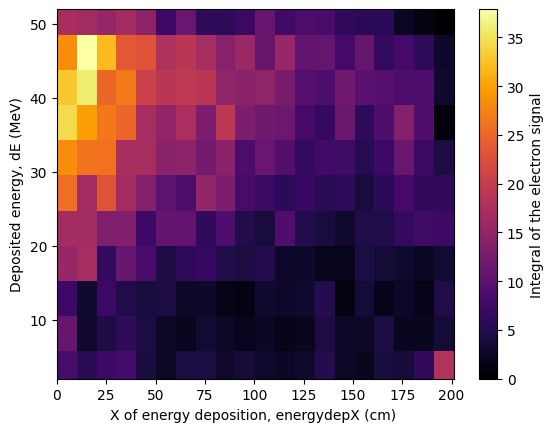

In [8]:
f = np.where((integral_signal<20000) & (dE>1) & (dE<56))

x = np.array(energydepX)[f]
y = np.array(dE)[f]
z = np.array(integral_signal)[f]
z_normalized = (z - min(z)) / (max(z) - min(z))

colormap = plt.get_cmap('inferno')

bins = [20, 11] # bins --> (width 10cm in dEX, X) and (width = 5MeV in dE, Y)
print(bins)
plt.hist2d(x, y, weights=z_normalized, bins=bins, cmap=colormap)
cbar = plt.colorbar()
cbar.set_label('Integral of the electron signal') 

plt.ylim(2,52)
plt.xlabel('X of energy deposition, energydepX (cm) ')
plt.ylabel('Deposited energy, dE (MeV)')
plt.show()